In [1]:
import mne
import pybv
import mne_bids
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy

requirements for a function to write BIDS: 
1. data 
2. channel names (maybe wrapper for those channel names)
3. BIDS specifications: (BIDS_path, subject_id, session, task, run)
    
 - BIDS need to be written into brainvision! 


 save raw file since spm files 
 1. cannot be read in python 
 2. .dat files are read as raw_byte streams (not in array shapes) 
 3. there exists no spm eeg python reader, and the file_array type in 
 Matlab is of SPM type 

### read .mat struct files

In [2]:
#from https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

### sub002

#### run BIDS_save_480NI57_REST_MEDON-20200130T111458.DATA.mat

In [3]:
dat = loadmat("sub002\\ses-20200130\\run_480NI57_REST_MEDON - 20200130T111458\\BIDS_save_480NI57_REST_MEDON-20200130T111458.DATA.mat")

In [4]:
dat["BIDS_struct_save"]["data"].shape

(27, 1232738)

In [5]:
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'EEG_Cz',
 'EEG_Fz',
 'ECOG_L1',
 'ECOG_L2',
 'ECOG_L3',
 'ECOG_L4',
 'ECOG_L5',
 'ECOG_L6',
 'BIP 01',
 'BIP 02']

In [6]:
dat["BIDS_struct_save"]["data"][26,:].shape

(1232738,)

Text(0.5, 0, 'Time [s]')

C:\Users\ICN_admin\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ICN_admin\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


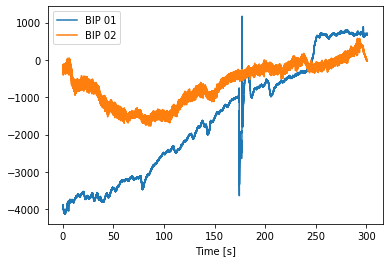

In [7]:
fsample = dat["BIDS_struct_save"]["fsample"]
time_ = np.arange(0, dat["BIDS_struct_save"]["data"][26,:].shape[0],1)*1/fsample
plt.plot(time_,dat["BIDS_struct_save"]["data"][26,:], label='BIP 01')
plt.plot(time_,dat["BIDS_struct_save"]["data"][25,:], label='BIP 02')
plt.legend()
plt.xlabel("Time [s]")

Text(0.5, 0, 'Time [s]')

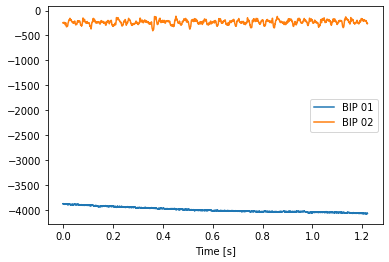

In [8]:
time_ = np.arange(0, dat["BIDS_struct_save"]["data"][26,:5000].shape[0],1)*1/fsample
plt.plot(time_,dat["BIDS_struct_save"]["data"][26,:5000], label='BIP 01')
plt.plot(time_,dat["BIDS_struct_save"]["data"][25,:5000], label='BIP 02')
plt.legend()
plt.xlabel("Time [s]")

In [9]:
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2", "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1"]

In [10]:
dat["BIDS_struct_save"]["fsample"]

4096

In [13]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200130"
task = "restMEDON20200130T111458"
run = "0"
fsample = dat["BIDS_struct_save"]["fsample"]
ieegdata = dat["BIDS_struct_save"]["data"]

In [30]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

Creating RawArray with float64 data, n_channels=27, n_times=1232738
    Range : 0 ... 1232737 =      0.000 ...   300.961 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...


<RawBrainVision | dummy_write.eeg, 27 x 1232738 (300.8 s), ~57 kB, data not loaded>

In [31]:
bv_raw

<RawBrainVision | dummy_write.eeg, 27 x 1232738 (300.8 s), ~57 kB, data not loaded>

In [32]:
bids_basename

BIDSPath(
root: C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin
datatype: None
basename: sub-002_ses-20200130_task-restMEDON20200130T111458_run-0)

In [34]:
bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    },
    "hand": {
        "Description": "Handedness of the participant",
        "Levels": {
            "R": "right",
            "L": "left",
            "A": "ambidextrous"
        }
    }
}

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\dataset_description

<ipython-input-34-861b9fc31231>:2: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200130\sub-002_ses-20200130_scans.tsv'...

filename	acq_time
ieeg/sub-002_ses-20200130_task-restMEDON20200130T111458_run-0_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200130\sub-002_ses-20200130_scans.tsv entry with ieeg\sub-002_ses-20200130_task-restMEDON20200130T111458_run-0_ieeg.vhdr.


#### run 480NI57_REST_MEDON_AVGREF-20200130T112142.DATA

In [61]:
dat = loadmat("sub002\\ses-20200130\\run_480NI57_REST_MEDON_AVGREF - 20200130T112142\\BIDS_save_480NI57_REST_MEDON_AVGREF-20200130T112142.DATA.mat")

In [62]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200130"
task = "restMEDONAVGREF20200130T112142"
run = "1"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [63]:
labels

['LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'EEG_Cz',
 'EEG_Fz',
 'ECOG_L1',
 'ECOG_L2',
 'ECOG_L3',
 'ECOG_L4',
 'ECOG_L5',
 'ECOG_L6',
 'BIP 01',
 'BIP 02']

In [64]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2", "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1"]

In [65]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=26, n_times=826710
    Range : 0 ... 826709 =      0.000 ...   201.833 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-65-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200130\sub-002_ses-20200130_scans.tsv'...

filename	acq_time
ieeg/sub-002_ses-20200130_task-restMEDON20200130T111458_run-0_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200130_task-restMEDONAVGREF20200130T112142_run-1_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200130\sub-002_ses-20200130_scans.tsv entry with ieeg\sub-002_ses-20200130_task-restMEDONAVGREF20200130T112142_run-1_ieeg.vhdr.


#### AO session sub002\ses-20200131\AO 

In [92]:
dat = loadmat("sub002\\ses-20200131\\AO\\BIDS_save_480ni57_evoked_202001310001.mat")

In [93]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200131"
task = "evoked202001310001"
run = "0"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [94]:
fsample

1375

In [95]:
labels

['CECOG_LF_1___02___STNR234',
 'CECOG_LF_1___03___STNR567',
 'CECOG_LF_1___05___STNL1',
 'CECOG_LF_1___06___STNL234',
 'CECOG_LF_1___07___STNL567',
 'CECOG_LF_1___11___ECOGL1',
 'CECOG_LF_1___12___ECOGL2',
 'CECOG_LF_1___13___ECOGL3',
 'CECOG_LF_1___14___ECOGL4',
 'CECOG_LF_1___15___ECOGL5',
 'CECOG_LF_1___16___ECOGL6']

In [96]:
ieegdata.shape

(11, 83271)

In [97]:
ch_labels = ["LFP_STN_R_234", "LFP_STN_R_567","LFP_BS_STN_L_1","LFP_STN_L_234",
          "LFP_STN_L_567","ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6"]

In [98]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=11, n_times=83271
    Range : 0 ... 83270 =      0.000 ...    60.560 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
       

<ipython-input-98-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### run BIDS_save_480ni57_evoked_202001310002

In [99]:
dat = loadmat("sub002\\ses-20200131\\AO\\BIDS_save_480ni57_evoked_202001310002.mat")

In [100]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200131"
task = "evoked202001310002"
run = "1"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [101]:
labels

['CECOG_LF_1___02___STNR234',
 'CECOG_LF_1___03___STNR567',
 'CECOG_LF_1___05___STNL1',
 'CECOG_LF_1___06___STNL234',
 'CECOG_LF_1___07___STNL567',
 'CECOG_LF_1___11___ECOGL1',
 'CECOG_LF_1___12___ECOGL2',
 'CECOG_LF_1___13___ECOGL3',
 'CECOG_LF_1___14___ECOGL4',
 'CECOG_LF_1___15___ECOGL5',
 'CECOG_LF_1___16___ECOGL6']

In [102]:
ch_labels = ["LFP_STN_R_234", "LFP_STN_R_567","LFP_BS_STN_L_1","LFP_STN_L_234",
          "LFP_STN_L_567","ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6"]

In [103]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=11, n_times=126288
    Range : 0 ... 126287 =      0.000 ...    91.845 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-103-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### run BIDS_save_480ni57_evoked_202001310003

In [104]:
dat = loadmat("sub002\\ses-20200131\\AO\\BIDS_save_480ni57_evoked_202001310003.mat")

In [105]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200131"
task = "evoked202001310003"
run = "2"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [106]:
labels

['CECOG_LF_1___02___STNR234',
 'CECOG_LF_1___03___STNR567',
 'CECOG_LF_1___05___STNL1',
 'CECOG_LF_1___06___STNL234',
 'CECOG_LF_1___07___STNL567',
 'CECOG_LF_1___11___ECOGL1',
 'CECOG_LF_1___12___ECOGL2',
 'CECOG_LF_1___13___ECOGL3',
 'CECOG_LF_1___14___ECOGL4',
 'CECOG_LF_1___15___ECOGL5',
 'CECOG_LF_1___16___ECOGL6']

In [107]:
ch_labels = ["LFP_STN_R_234", "LFP_STN_R_567","LFP_BS_STN_L_1","LFP_STN_L_234",
          "LFP_STN_L_567","ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6"]

In [108]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=11, n_times=728127
    Range : 0 ... 728126 =      0.000 ...   529.546 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-108-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### run BIDS_save_480ni57_rest_202001310001

In [109]:
dat = loadmat("sub002\\ses-20200131\\AO\\BIDS_save_480ni57_rest_202001310001.mat")

In [110]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200131"
task = "rest202001310001"
run = "3"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [111]:
labels

['CECOG_LF_1___02___STNR234',
 'CECOG_LF_1___03___STNR567',
 'CECOG_LF_1___05___STNL1',
 'CECOG_LF_1___06___STNL234',
 'CECOG_LF_1___07___STNL567',
 'CECOG_LF_1___11___ECOGL1',
 'CECOG_LF_1___12___ECOGL2',
 'CECOG_LF_1___13___ECOGL3',
 'CECOG_LF_1___14___ECOGL4',
 'CECOG_LF_1___15___ECOGL5',
 'CECOG_LF_1___16___ECOGL6']

In [112]:
ch_labels = ["LFP_STN_R_234", "LFP_STN_R_567","LFP_BS_STN_L_1","LFP_STN_L_234",
          "LFP_STN_L_567","ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6"]

In [113]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=11, n_times=442712
    Range : 0 ... 442711 =      0.000 ...   321.972 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-113-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### run BIDS_save_480ni57_rota_selfpaced_right_202001310001

In [115]:
dat = loadmat("sub002\\ses-20200131\\AO\\BIDS_save_480ni57_rota_selfpaced_right_202001310001.mat")

In [116]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200131"
task = "selfpacedrotation202001310001"
run = "4"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [117]:
labels

['CECOG_LF_1___02___STNR234',
 'CECOG_LF_1___03___STNR567',
 'CECOG_LF_1___05___STNL1',
 'CECOG_LF_1___06___STNL234',
 'CECOG_LF_1___07___STNL567',
 'CECOG_LF_1___11___ECOGL1',
 'CECOG_LF_1___12___ECOGL2',
 'CECOG_LF_1___13___ECOGL3',
 'CECOG_LF_1___14___ECOGL4',
 'CECOG_LF_1___15___ECOGL5',
 'CECOG_LF_1___16___ECOGL6',
 'CANALOG_IN_1']

In [118]:
ch_labels = ["LFP_STN_R_234", "LFP_STN_R_567","LFP_BS_STN_L_1","LFP_STN_L_234",
          "LFP_STN_L_567","ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
            "ANALOG_ROT_R_1"]

In [119]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=12, n_times=613328
    Range : 0 ... 613327 =      0.000 ...   446.056 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-119-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### TMSI BIDS_save_480NI57_REST_AVGREF_20200131-20200131T104719.DATA

In [120]:
dat = loadmat("sub002\\ses-20200131\\TMSI\\BIDS_save_480NI57_REST_AVGREF_20200131-20200131T104719.DATA.mat")

In [121]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200131"
task = "restAGREF20200131T104719"
run = "5"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [122]:
labels

['LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L1',
 'ECOG_L2',
 'ECOG_L3',
 'ECOG_L4',
 'ECOG_L5',
 'ECOG_L6']

In [123]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6"]

In [124]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=22, n_times=732218
    Range : 0 ... 732217 =      0.000 ...   178.764 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-124-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### BIDS_save_480NI57_REST_MEDON_AVGREF-20200130T112142.DATA

In [125]:
dat = loadmat("sub002\\ses-20200131\\TMSI\\BIDS_save_480NI57_REST_MEDON_AVGREF-20200130T112142.DATA.mat")

In [126]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200131"
task = "restMEDONAVGREF20200130T112142"
run = "6"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [127]:
labels

['LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'EEG_Cz',
 'EEG_Fz',
 'ECOG_L1',
 'ECOG_L2',
 'ECOG_L3',
 'ECOG_L4',
 'ECOG_L5',
 'ECOG_L6',
 'BIP 01',
 'BIP 02']

In [128]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2","ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
            "EMG_TM_BR_R_1", "EMG_TM_BR_L_1"]

In [129]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=26, n_times=826710
    Range : 0 ... 826709 =      0.000 ...   201.833 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-129-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### BIDS_save_480NI57_REST_MEDON-20200130T111458.DATA

In [134]:
dat = loadmat("sub002\\ses-20200131\\TMSI\\BIDS_save_480NI57_REST_MEDON-20200130T111458.DATA.mat")

In [135]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200131"
task = "restMEDON20200130T111458"
run = "7"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [136]:
labels

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'EEG_Cz',
 'EEG_Fz',
 'ECOG_L1',
 'ECOG_L2',
 'ECOG_L3',
 'ECOG_L4',
 'ECOG_L5',
 'ECOG_L6',
 'BIP 01',
 'BIP 02']

In [137]:
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2","ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
            "EMG_TM_BR_R_1", "EMG_TM_BR_L_1"]

In [138]:
len(ch_labels)

27

In [139]:
ieegdata.shape

(27, 1232738)

In [140]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=27, n_times=1232738
    Range : 0 ... 1232737 =      0.000 ...   300.961 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
   

<ipython-input-140-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200131\sub-002_ses-20200131_scans.tsv'...

filename	acq_time
ieeg/sub-002_ses-20200131_task-evoked202001310001_run-0_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200131_task-evoked202001310002_run-1_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200131_task-evoked202001310003_run-2_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200131_task-rest202001310001_run-3_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200131_task-restAGREF20200131T104719_run-5_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200131\sub-002_ses-20200131_scans.tsv entry with ieeg\sub-002_ses-20200131_task-restMEDON20200130T111458_run-7_ieeg.vhdr.


#### BIDS_save_480NI57_REST_STNR8REF_20200131-20200131T105228.DATA

In [141]:
dat = loadmat("sub002\\ses-20200131\\TMSI\\BIDS_save_480NI57_REST_STNR8REF_20200131-20200131T105228.DATA.mat")

In [142]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200131"
task = "restSTNR8REF20200131T105228"
run = "8"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [143]:
labels

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L1',
 'ECOG_L2',
 'ECOG_L3',
 'ECOG_L4',
 'ECOG_L5',
 'ECOG_L6']

In [144]:
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6"]

In [145]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=22, n_times=743208
    Range : 0 ... 743207 =      0.000 ...   181.447 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-145-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### BIDS_save_480NI57_SPEECH_STNR8REF_20200131-20200131T105546.DATA

In [150]:
dat = loadmat("sub002\\ses-20200131\\TMSI\\BIDS_save_480NI57_SPEECH_STNR8REF_20200131-20200131T105546.DATA")

In [151]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200131"
task = "speechSTN8REF20200131T105546"
run = "9"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [152]:
labels

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L1',
 'ECOG_L2',
 'ECOG_L3',
 'ECOG_L4',
 'ECOG_L5',
 'ECOG_L6']

In [153]:
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
           "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6"]

In [154]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=22, n_times=915908
    Range : 0 ... 915907 =      0.000 ...   223.610 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-154-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200131\sub-002_ses-20200131_scans.tsv'...

filename	acq_time
ieeg/sub-002_ses-20200131_task-evoked202001310001_run-0_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200131_task-evoked202001310002_run-1_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200131_task-evoked202001310003_run-2_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200131_task-rest202001310001_run-3_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200131_task-restAGREF20200131T104719_run-5_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200131\sub-002_ses-20200131_scans.tsv entry with ieeg\sub-002_ses-20200131_task-speechSTN8REF20200131T105546_run-9_ieeg.vhdr.


### session 20200201 run BIDS_save_480NI57_rest_stim_off_202002013

In [194]:
dat = loadmat("sub002\\ses-20200201\\AO\\BIDS_save_480NI57_rest_stim_off_202002013.mat")

In [195]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200201"
task = "restSTIMOFF202002013"
run = "0"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [196]:
labels

['CECOG_LF_1___01___STNR1',
 'CECOG_LF_1___02___STNR2',
 'CECOG_LF_1___03___STNR3',
 'CECOG_LF_1___04___STNR4',
 'CECOG_LF_1___05___STNR5',
 'CECOG_LF_1___06___STNR6',
 'CECOG_LF_1___07___STNR7',
 'CECOG_LF_1___08___STNR8',
 'CECOG_LF_1___09___STNL1',
 'CECOG_LF_1___10___STNL2',
 'CECOG_LF_1___11___STNL3',
 'CECOG_LF_1___12___STNL4',
 'CECOG_LF_1___13___STNL5',
 'CECOG_LF_1___14___STNL6',
 'CECOG_LF_1___15___STNL7',
 'CECOG_LF_1___16___STNL8',
 'CEEG_2___01___ECOGL1',
 'CEEG_2___02___ECOGL2',
 'CEEG_2___03___ECOGL3',
 'CEEG_2___04___ECOGL4',
 'CEEG_2___05___ECOGL5',
 'CEEG_2___06___ECOGL6',
 'CEEG_2___07___EEG_Cz',
 'CEEG_2___08___EEG_Fz',
 'CEEG_2___09___EMG_BcR1',
 'CEEG_2___10___EMG_BcR2',
 'CEEG_2___11___EMG_FxR1',
 'CEEG_2___12___EMG_FxR2']

In [197]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Fz__1", "EMG_TM_BR_1", "EMG_TM_BR_2", "EMG_TM_FDI_1",
          "EMG_TM_FDI_2"]

In [198]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=28, n_times=241786
    Range : 0 ... 241785 =      0.000 ...   175.844 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-198-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_480NI57_rest_stimon_stnl1-8_0.8mA_20200201

In [199]:
dat = loadmat("sub002\\ses-20200201\\AO\\BIDS_save_480NI57_rest_stimon_stnl1-8_0.8mA_20200201.mat")

In [200]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200201"
task = "restSTIMONSTNL1TO0DOT8mA"
run = "1"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [201]:
labels

['CECOG_LF_1___01___STNR1',
 'CECOG_LF_1___02___STNR2',
 'CECOG_LF_1___03___STNR3',
 'CECOG_LF_1___04___STNR4',
 'CECOG_LF_1___05___STNR5',
 'CECOG_LF_1___06___STNR6',
 'CECOG_LF_1___07___STNR7',
 'CECOG_LF_1___08___STNR8',
 'CECOG_LF_1___09___STNL1',
 'CECOG_LF_1___10___STNL2',
 'CECOG_LF_1___11___STNL3',
 'CECOG_LF_1___12___STNL4',
 'CECOG_LF_1___13___STNL5',
 'CECOG_LF_1___14___STNL6',
 'CECOG_LF_1___15___STNL7',
 'CECOG_LF_1___16___STNL8',
 'CEEG_2___01___ECOGL1',
 'CEEG_2___02___ECOGL2',
 'CEEG_2___03___ECOGL3',
 'CEEG_2___04___ECOGL4',
 'CEEG_2___05___ECOGL5',
 'CEEG_2___06___ECOGL6',
 'CEEG_2___07___EEG_Cz',
 'CEEG_2___08___EEG_Fz',
 'CEEG_2___09___EMG_BcR1',
 'CEEG_2___10___EMG_BcR2',
 'CEEG_2___11___EMG_FxR1',
 'CEEG_2___12___EMG_FxR2']

In [202]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Fz__1", "EMG_TM_BR_1", "EMG_TM_BR_2", "EMG_TM_FDI_1",
          "EMG_TM_FDI_2"]

In [203]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=28, n_times=418229
    Range : 0 ... 418228 =      0.000 ...   304.166 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-203-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### BIDS_save_480NI57_rota_selfp_r_stimoff_20200201

In [204]:
dat = loadmat("sub002\\ses-20200201\\AO\\BIDS_save_480NI57_rota_selfp_r_stimoff_20200201.mat")

In [205]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200201"
task = "selfpacedrotationSTIMOFF"
run = "2"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [206]:
labels

['CECOG_LF_1___01___STNR1',
 'CECOG_LF_1___02___STNR2',
 'CECOG_LF_1___03___STNR3',
 'CECOG_LF_1___04___STNR4',
 'CECOG_LF_1___05___STNR5',
 'CECOG_LF_1___06___STNR6',
 'CECOG_LF_1___07___STNR7',
 'CECOG_LF_1___08___STNR8',
 'CECOG_LF_1___09___STNL1',
 'CECOG_LF_1___10___STNL2',
 'CECOG_LF_1___11___STNL3',
 'CECOG_LF_1___12___STNL4',
 'CECOG_LF_1___13___STNL5',
 'CECOG_LF_1___14___STNL6',
 'CECOG_LF_1___15___STNL7',
 'CECOG_LF_1___16___STNL8',
 'CEEG_2___01___ECOGL1',
 'CEEG_2___02___ECOGL2',
 'CEEG_2___03___ECOGL3',
 'CEEG_2___04___ECOGL4',
 'CEEG_2___05___ECOGL5',
 'CEEG_2___06___ECOGL6',
 'CEEG_2___07___EEG_Cz',
 'CEEG_2___08___EEG_Fz',
 'CEEG_2___09___EMG_BcR1',
 'CEEG_2___10___EMG_BcR2',
 'CEEG_2___11___EMG_FxR1',
 'CEEG_2___12___EMG_FxR2',
 'CANALOG_IN_1']

In [207]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Fz__1", "EMG_TM_BR_1", "EMG_TM_BR_2", "EMG_TM_FDI_1",
          "EMG_TM_FDI_2","ANALOG_ROTA_R_1"]

In [208]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=29, n_times=675534
    Range : 0 ... 675533 =      0.000 ...   491.297 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-208-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### BIDS_save_480ni57_rota_selfp_r_stimon_stnl1-8_0.8mA_202002010003

In [209]:
dat = loadmat("sub002\\ses-20200201\\AO\\BIDS_save_480ni57_rota_selfp_r_stimon_stnl1-8_0.8mA_202002010003.mat")

In [210]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200201"
task = "selfpacedrotationSTIMONL18TO0DOT8"
run = "3"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [211]:
labels

['CECOG_LF_1___01___STNR1',
 'CECOG_LF_1___02___STNR2',
 'CECOG_LF_1___03___STNR3',
 'CECOG_LF_1___04___STNR4',
 'CECOG_LF_1___05___STNR5',
 'CECOG_LF_1___06___STNR6',
 'CECOG_LF_1___07___STNR7',
 'CECOG_LF_1___08___STNR8',
 'CECOG_LF_1___09___STNL1',
 'CECOG_LF_1___10___STNL2',
 'CECOG_LF_1___11___STNL3',
 'CECOG_LF_1___12___STNL4',
 'CECOG_LF_1___13___STNL5',
 'CECOG_LF_1___14___STNL6',
 'CECOG_LF_1___15___STNL7',
 'CECOG_LF_1___16___STNL8',
 'CEEG_2___01___ECOGL1',
 'CEEG_2___02___ECOGL2',
 'CEEG_2___03___ECOGL3',
 'CEEG_2___04___ECOGL4',
 'CEEG_2___05___ECOGL5',
 'CEEG_2___06___ECOGL6',
 'CEEG_2___07___EEG_Cz',
 'CEEG_2___08___EEG_Fz',
 'CEEG_2___09___EMG_BcR1',
 'CEEG_2___10___EMG_BcR2',
 'CEEG_2___11___EMG_FxR1',
 'CEEG_2___12___EMG_FxR2',
 'CANALOG_IN_1']

In [212]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Fz__1", "EMG_TM_BR_1", "EMG_TM_BR_2", "EMG_TM_FDI_1",
          "EMG_TM_FDI_2","ANALOG_ROTA_R_1"]

In [213]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=29, n_times=578489
    Range : 0 ... 578488 =      0.000 ...   420.719 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-213-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### BIDS_save_480NI57_stim_2hz_stnl1-8_0.8mA_20200201

In [214]:
dat = loadmat("sub002\\ses-20200201\\AO\\BIDS_save_480NI57_stim_2hz_stnl1-8_0.8mA_20200201.mat")

In [215]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200201"
task = "restSTIM2Hz"
run = "4"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [216]:
labels

['CECOG_LF_1___01___STNR1',
 'CECOG_LF_1___02___STNR2',
 'CECOG_LF_1___03___STNR3',
 'CECOG_LF_1___04___STNR4',
 'CECOG_LF_1___05___STNR5',
 'CECOG_LF_1___06___STNR6',
 'CECOG_LF_1___07___STNR7',
 'CECOG_LF_1___08___STNR8',
 'CECOG_LF_1___09___STNL1',
 'CECOG_LF_1___10___STNL2',
 'CECOG_LF_1___11___STNL3',
 'CECOG_LF_1___12___STNL4',
 'CECOG_LF_1___13___STNL5',
 'CECOG_LF_1___14___STNL6',
 'CECOG_LF_1___15___STNL7',
 'CECOG_LF_1___16___STNL8',
 'CEEG_2___01___ECOGL1',
 'CEEG_2___02___ECOGL2',
 'CEEG_2___03___ECOGL3',
 'CEEG_2___04___ECOGL4',
 'CEEG_2___05___ECOGL5',
 'CEEG_2___06___ECOGL6',
 'CEEG_2___07___EEG_Cz',
 'CEEG_2___08___EEG_Fz',
 'CEEG_2___09___EMG_BcR1',
 'CEEG_2___10___EMG_BcR2',
 'CEEG_2___11___EMG_FxR1',
 'CEEG_2___12___EMG_FxR2']

In [217]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Fz__1", "EMG_TM_BR_1", "EMG_TM_BR_2", "EMG_TM_FDI_1",
          "EMG_TM_FDI_2"]

In [218]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=28, n_times=166240
    Range : 0 ... 166239 =      0.000 ...   120.901 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-218-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### TMSI BIDS_save_480NI57_REST_20200201_EARLOBEREF-20200201T113336.DATA

In [219]:
dat = loadmat("sub002\\ses-20200201\\TMSI\\BIDS_save_480NI57_REST_20200201_EARLOBEREF-20200201T113336.DATA.mat")

In [220]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200201"
task = "restEARLOBEREF"
run = "5"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [221]:
labels

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'EEG_Cz',
 'EEG_Fz',
 'ECOG_L1',
 'ECOG_L2',
 'ECOG_L3',
 'ECOG_L4',
 'ECOG_L5',
 'ECOG_L6']

In [222]:
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "EEG_TM_Cz__1", "EEG_TM_Fz__1", "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6"]

In [224]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=25, n_times=1230914
    Range : 0 ... 1230913 =      0.000 ...   300.516 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
   

<ipython-input-224-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200201\sub-002_ses-20200201_scans.tsv'...

filename	acq_time
ieeg/sub-002_ses-20200201_task-restEARLOBEREF_run-5_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200201_task-restSTIM2Hz_run-4_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200201_task-restSTIMOFF202002013_run-0_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200201_task-restSTIMONSTNL1TO0DOT8mA_run-1_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200201_task-selfpacedrotationSTIMOFF_run-2_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200201\sub-002_ses-20200201_scans.tsv entry with ieeg\sub-002_ses-20200201_task-restEARLOBEREF_run-5_ieeg.vhdr.


### BIDS_save_480NI57_REST_20200201_GREF-20200201T113050.DATA

In [225]:
dat = loadmat("sub002\\ses-20200201\\TMSI\\BIDS_save_480NI57_REST_20200201_GREF-20200201T113050.DATA.mat")

In [226]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200201"
task = "restGREF20200201T113050"
run = "6"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [227]:
labels

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'EEG_Cz',
 'EEG_Fz',
 'ECOG_L1',
 'ECOG_L2',
 'ECOG_L3',
 'ECOG_L4',
 'ECOG_L5',
 'ECOG_L6']

In [228]:
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "EEG_TM_Cz__1", "EEG_TM_Fz__1", "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6"]

In [229]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=25, n_times=117719
    Range : 0 ... 117718 =      0.000 ...    28.740 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
     

<ipython-input-229-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


#### BIDS_save_480NI57_REST_20200201_STNR8REF-20200201T114227.DATA

In [230]:
dat = loadmat("sub002\\ses-20200201\\TMSI\\BIDS_save_480NI57_REST_20200201_STNR8REF-20200201T114227.DATA.mat")

In [231]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "002"
session = "20200201"
task = "restSTNR8REF20200201T114227"
run = "7"

fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]

In [232]:
labels

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'EEG_Cz',
 'EEG_Fz',
 'ECOG_L1',
 'ECOG_L2',
 'ECOG_L3',
 'ECOG_L4',
 'ECOG_L5',
 'ECOG_L6']

In [233]:
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2","LFP_BS_STN_R_3","LFP_BS_STN_R_4",
          "LFP_BS_STN_R_5","LFP_BS_STN_R_6","LFP_BS_STN_R_7","LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
          "LFP_BS_STN_L_5","LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "EEG_TM_Cz__1", "EEG_TM_Fz__1", "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6"]

In [234]:
info = mne.create_info(ch_labels, fsample, ch_types='ecog')
raw = mne.io.RawArray(ieegdata, info)
raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

#bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
#                                            task=task, run=run)
bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                            task=task, run=run, root=BIDS_path)
pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

# set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
mapping = {}
for ch in range(len(bv_raw.info['ch_names'])):
    mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
bv_raw.set_channel_types(mapping)

bv_raw.info['line_freq'] = 50
mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

#  remove dummy file
os.remove('dummy_write.vhdr')
os.remove('dummy_write.eeg')
os.remove('dummy_write.vmrk')

Creating RawArray with float64 data, n_channels=25, n_times=1248962
    Range : 0 ... 1248961 =      0.000 ...   304.922 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
   

<ipython-input-234-0f011c86cb5a>:20: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200201\sub-002_ses-20200201_scans.tsv'...

filename	acq_time
ieeg/sub-002_ses-20200201_task-restEARLOBEREF_run-5_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200201_task-restGREF20200201T113050_run-6_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200201_task-restSTIM2Hz_run-4_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200201_task-restSTIMOFF202002013_run-0_ieeg.vhdr	n/a
ieeg/sub-002_ses-20200201_task-restSTIMONSTNL1TO0DOT8mA_run-1_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-002\ses-20200201\sub-002_ses-20200201_scans.tsv entry with ieeg\sub-002_ses-20200201_task-restSTNR8REF20200201T114227_run-7_ieeg.vhdr.
